# Pathway Analysis with PathSingle

In [45]:
import scanpy as sc
import pandas as pd
import scanpy.external as sce
from metrics import *


from warnings import filterwarnings
filterwarnings('ignore')


sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 numpy==1.26.4 scipy==1.13.1 pandas==2.0.3 scikit-learn==1.5.0 statsmodels==0.14.2 pynndescent==0.5.12


### Data Preparation
The challenge data is available on AWS cloud servers. You need to register to the challenge here:
- https://www.topcoder.com/challenges/25f60820-2e69-444b-bc03-490686af2c87?tab=details

and then go the the forum links and download sc_training.h5ad from:

- https://discussions.topcoder.com/discussion/25381/challenge-specifications-and-data-for-cancer-immunotherapy-data-science-grand-challenge

In [27]:
adata = sc.read_h5ad('./data/sc_training.h5ad')
#28697 cells × 15077 genes.
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

In [ ]:
# adata.X stores the stadard-normalized data, but you can also reconstruct it using adata.layers['rawcounts']
# make a copy of normalized logcounts
#adata.layers['normalized_logcounts'] = adata.X.copy()
# standard normalization
#adata.X = adata.layers['rawcounts'].copy()

#sc.pp.normalize_total(adata, target_sum=5e3)
#sc.pp.log1p(adata)

#adata.raw.X[:5,:5].toarray()

### Data exploration

In [8]:
adata.obs.head()

,gRNA_maxID,state,condition,lane
053l1_AAACCTGAGATGTCGG-1,ONE-NON-GENE-SITE-7,terminal exhausted,Unperturbed,lane1
053l1_AAACCTGAGCAACGGT-1,Tox2-3,effector,Tox2,lane1
053l1_AAACCTGAGTACGACG-1,Tpt1-2,effector,Tpt1,lane1
053l1_AAACCTGAGTCGTTTG-1,Tox2-3,terminal exhausted,Tox2,lane1
053l1_AAACCTGAGTGAAGAG-1,Tcf7-2,effector,Tcf7,lane1


### Run Magic

In [6]:
%%time
print(adata.X[:1,:5].toarray())
sce.pp.magic(adata, name_list='all_genes', knn=5)
print(adata.X[:1,:5])

computing MAGIC
  Running MAGIC with `solver='exact'` on 15077-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:09:53)
CPU times: total: 5min 9s
Wall time: 9min 58s


In [9]:
print(adata.obs_names[:5])
print(adata.var_names[:5])

Index(['053l1_AAACCTGAGATGTCGG-1', '053l1_AAACCTGAGCAACGGT-1',
       '053l1_AAACCTGAGTACGACG-1', '053l1_AAACCTGAGTCGTTTG-1',
       '053l1_AAACCTGAGTGAAGAG-1'],
      dtype='object')
Index(['Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1'], dtype='object')


### Run PathSingle

In [10]:
calc_activity_from_adata(adata)

### Cluster With KMeans

In [39]:
bdata = sc.read_csv('./data/output_activity_st3.csv')
print(bdata.obs_names[:5]) #The observations have to be the cell names.
print(bdata.var_names[:5]) #The variables have to be the pathways names.

Index(['053l1_AAACCTGAGATGTCGG-1', '053l1_AAACCTGAGCAACGGT-1',
       '053l1_AAACCTGAGTACGACG-1', '053l1_AAACCTGAGTCGTTTG-1',
       '053l1_AAACCTGAGTGAAGAG-1'],
      dtype='object')
Index(['1 4-Dichlorobenzene degradation(Kegg)',
       '1- and 2-Methylnaphthalene degradation(Kegg)',
       '3-Chloroacrylic acid degradation(Kegg)',
       'Acute myeloid leukemia(Kegg)', 'Adherens junction(Kegg)'],
      dtype='object')


computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


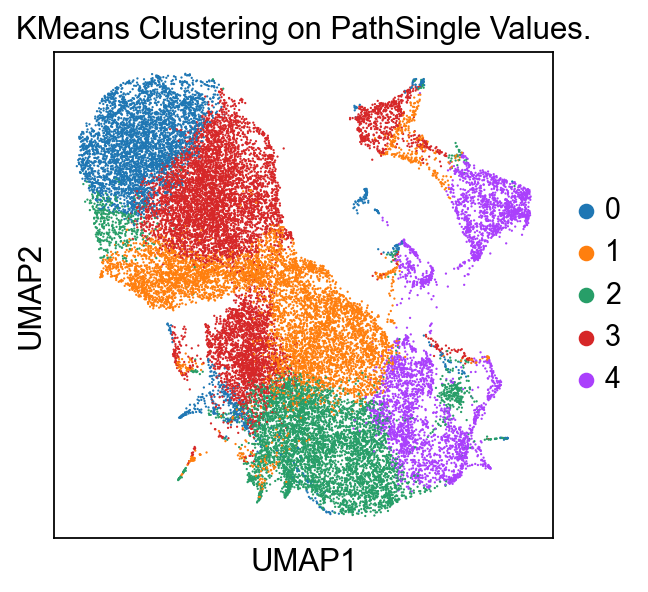

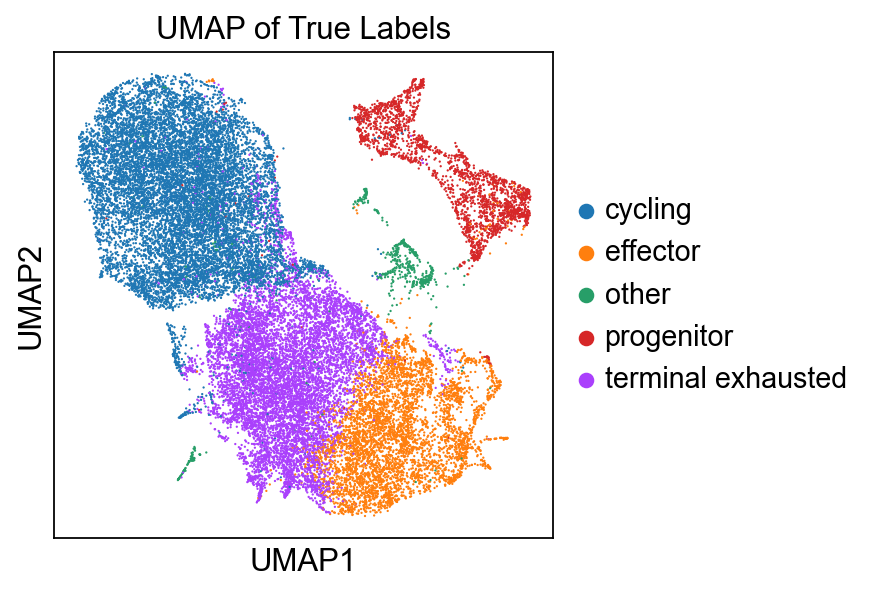

CPU times: total: 36.3 s
Wall time: 33.2 s


In [43]:
%%time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap


# Scale the data
scaler = StandardScaler()
bdata.X = scaler.fit_transform(bdata.X)

# Perform PCA for Dimensionality Reduction
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

#Perform KMeans clustering.
kmeans = KMeans(n_clusters=5, random_state=0).fit(bdata.X)
bdata.obs['kmeans'] = pd.Categorical(kmeans.labels_)

#Perform PCA and UMAP.
#umap_model = umap.UMAP(n_neighbors=15, random_state=0)
#umap_coords = umap_model.fit_transform(df)
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=30, n_pcs=50)
sc.tl.umap(bdata, min_dist=0.3)

#Add the UMAP coordinates and clustering results to the AnnData object.
#bdata.obs['X_umap'] = bdata.obsm['X_umap']
#adata.obs['kmeans4'] = pd.Categorical(kmeans.labels_)

#Add the true labels from the original 'adata'.
bdata.obs['state'] = adata.obs.state

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(bdata, color=["kmeans"], title="KMeans Clustering on PathSingle Values.")
sc.pl.umap(bdata, color=["state"], title="UMAP of True Labels")
#sc.pl.umap(bdata, color=['state'], palette='Accent', legend_loc='right margin')

In [46]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = bdata.X

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

#Special accuracy function.
print(acc(adata.obs.condition.map({'ctrl':0, 'stim':1}), kmeans.labels_))

Silhouette Score: 0.13966581225395203
Calinski-Harabasz Index: 4833.945627700665


MemoryError: Unable to allocate 6.14 GiB for an array with shape (28697, 28697) and data type float64

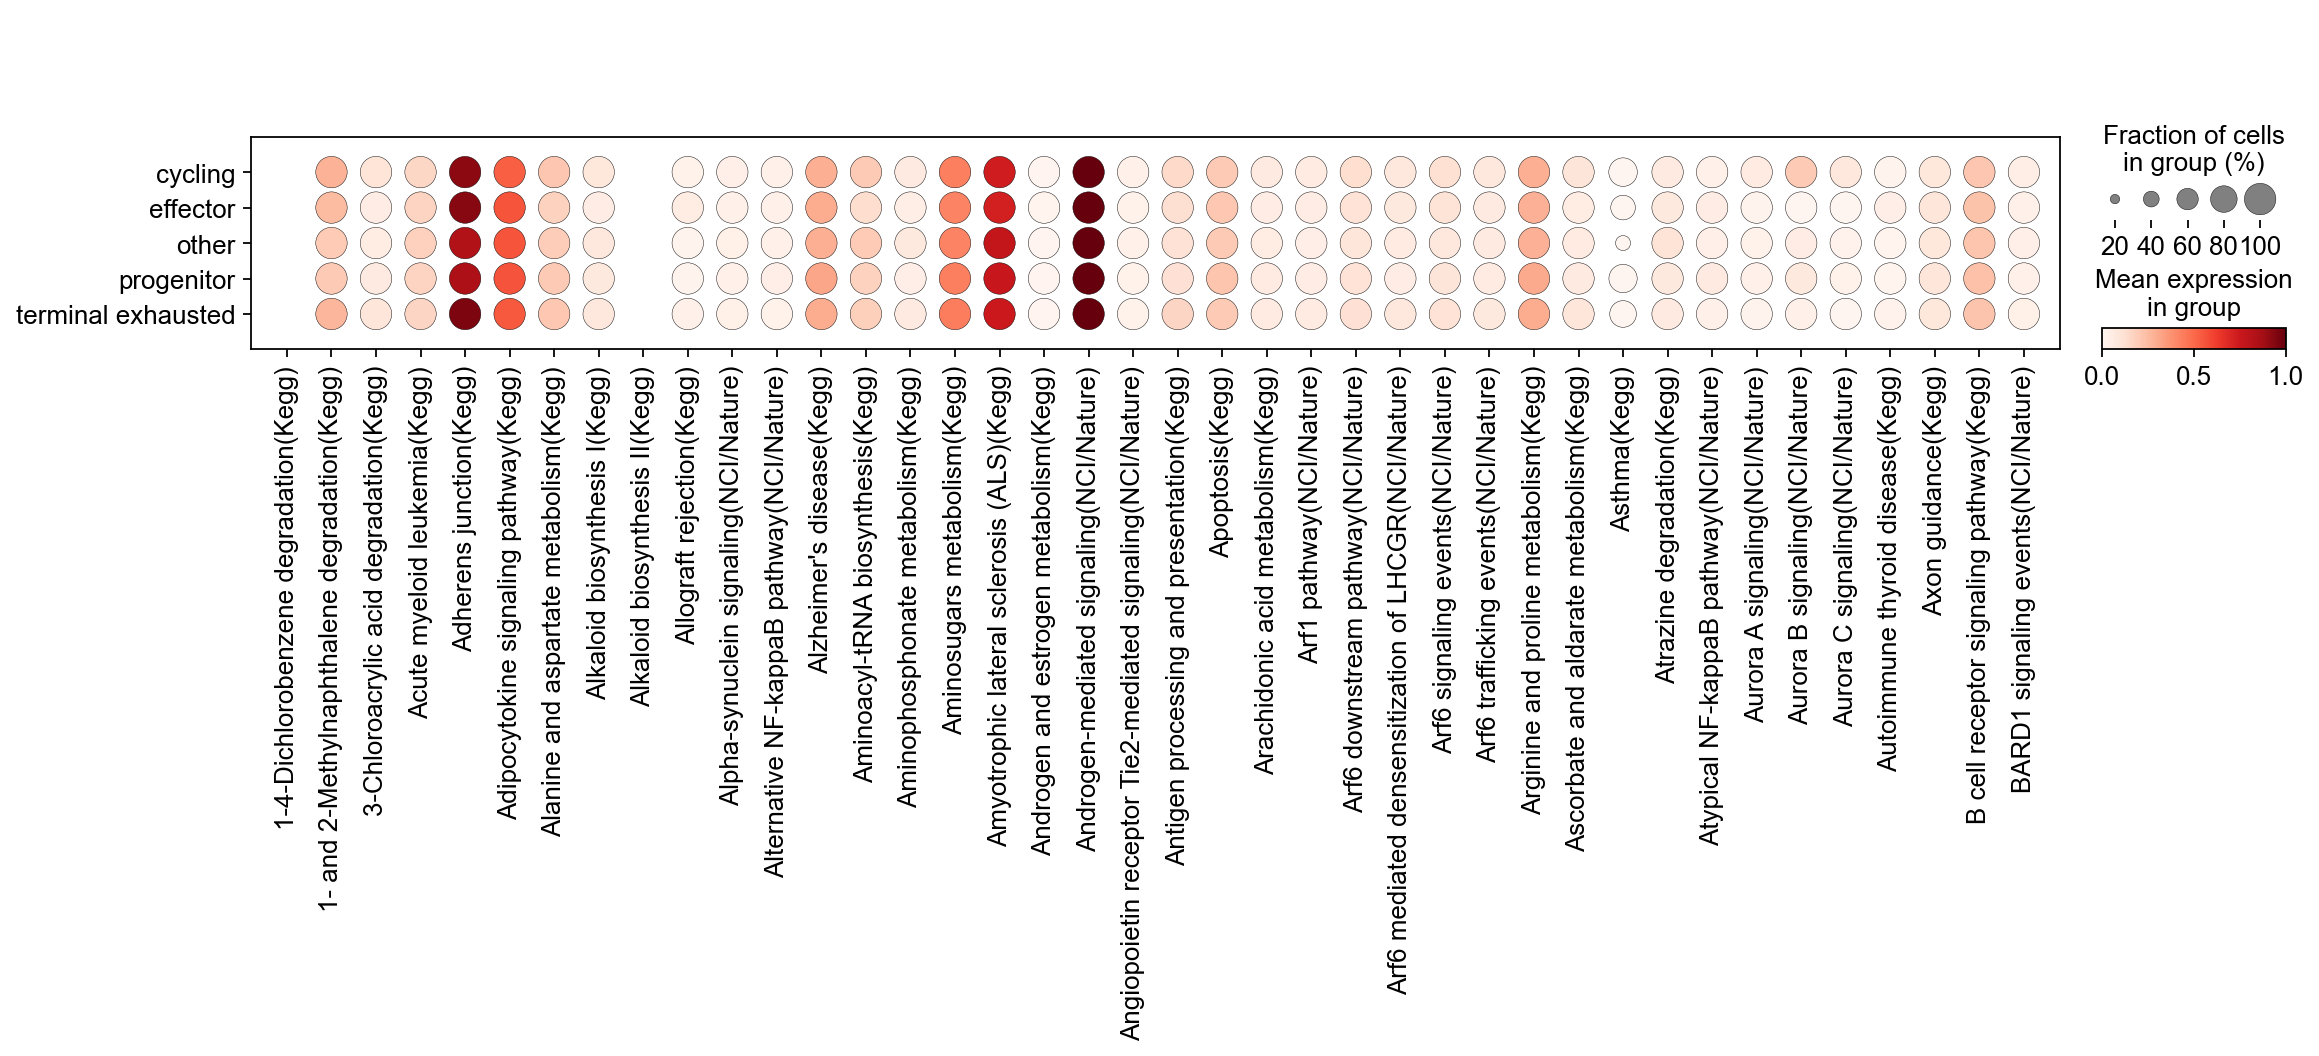

In [24]:
var_names = bdata.var_names[0:40]
sc.pl.dotplot(bdata, var_names=var_names, groupby='state')